# June 4, 2022: creating simulated data: white noise

The goal is to see how well the NN can do with data with very little noise. Is that a trivial problem to learn? Or very difficult even with just a little bit of noise.
Real data have a ton of noise.

1. adding white noise to the mean time series of each condition
2. training models and checking their performances

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import scipy as sp

import torch
import torch.nn as nn 
print(torch.cuda.is_available())

import pickle, time, random
# import neural_structured_learning as nsl
from tqdm import tqdm
import json
from itertools import combinations, product
from operator import add
import copy
from glob import glob
from sklearn import metrics

# explanation tools
import captum

# plotting
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

# nilearn
from nilearn import image
from nilearn import masking
from nilearn import plotting

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'explainable-ai')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/jun22"

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils as dataset_utils
import helpers.base_model as base_model
import helpers.model_definitions as model_definitions

# cuda device
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

True


2022-06-07 20:00:24.060975: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Using cuda:1 device


In [2]:
def plot_training_history(history, best_epoch):
    fig, axs = plt.subplots(
        nrows=2, ncols=1,
        figsize=(11,5),
        dpi=150
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.5
    )

    ax = axs[0]
    ax.plot(history['train_loss'], color='tomato', linestyle='-.', label='training_loss')
    ax.plot(history['valid_loss'], color='forestgreen', label='valid_loss')
    ax.set_ylabel(f"losses")
    ax.set_xlabel(f"epochs")
    ax.legend()
    ax.grid(True)

    ax = axs[1]
    ax.plot(history['train_acc'], color='tomato', linestyle='-.', label='training_acc')
    ax.plot(history['valid_acc'], color='forestgreen', label='valid_acc')
    ax.axvline(x=best_epoch, ymax=1.0, label='best_epoch')
    ax.set_ylabel(f"accuracies")
    ax.set_xlabel(f"epochs")
    ax.set_ylim(0.5, 1.0)
    ax.set_title(f"valid acc. {np.max(history['valid_acc']):.3f}")
    ax.legend()
    ax.grid(True)

def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize=(3*args.num_classes, 3*args.num_classes))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(args.num_classes))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

In [3]:
def train(model, X, y, opt, criterion, permutation):
    epoch_losses = []
    epoch_accs = []

    model.train()

    for i in range(0, X.size()[0], args.batch_size):

        opt.zero_grad()

        indices = permutation[i:i + args.batch_size]
        batch_x, batch_y = X[indices], y[indices]

        y_pred = model(batch_x,)
        loss = criterion(
            y_pred.view(-1, args.out_dim), 
            batch_y.view(-1)
        )

        acc = model.accuracy(y_pred, batch_y)

        loss.backward()
        opt.step()

        epoch_losses += [loss.item()]
        epoch_accs += [acc.item()]

    return  np.sum(epoch_losses) / len(epoch_losses), np.sum(epoch_accs) / len(epoch_accs)


def evaluate(model, X, y, criterion, permutation):
    epoch_losses = []
    epoch_accs = []

    model.eval()

    with torch.no_grad():
        for i in range(0, X.size()[0], args.batch_size):
            indices = permutation[i:i + args.batch_size]
            batch_x, batch_y = X[indices], y[indices]

            y_pred = model(batch_x,)
            loss = criterion(
                y_pred.view(-1, args.out_dim), 
                batch_y.view(-1)
            )

            acc = model.accuracy(y_pred, batch_y)

            epoch_losses += [loss.item()]
            epoch_accs += [acc.item()]
    
    return np.sum(epoch_losses) / len(epoch_losses), np.sum(epoch_accs) / len(epoch_accs)

In [4]:
def fit(data, model, criterion, optimizer):
    X_tr, y_tr, X_val, y_val, X_te, y_te = data
    best_valid_loss = float('inf')

    train_loss, train_acc = np.zeros(args.num_epochs), np.zeros(args.num_epochs)
    valid_loss, valid_acc = np.zeros(args.num_epochs), np.zeros(args.num_epochs)

    for epoch in range(args.num_epochs):
        train_loss[epoch], train_acc[epoch] = train(model, X_tr, y_tr, optimizer, criterion, permut_train)
        valid_loss[epoch], valid_acc[epoch] = evaluate(model, X_val, y_val, criterion, permut_valid)

        if valid_loss[epoch] < best_valid_loss:
            best_valid_loss = valid_loss[epoch]
            # torch.save(model.state_dict(), model_file)
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        
        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

    history = {
        'train_loss': train_loss,
        'train_acc': train_acc,
        'valid_loss': valid_loss,
        'valid_acc': valid_acc
    }

    # torch.save(model.state_dict(), model_file)
    # with open(history_file, 'wb') as f:
    #     pickle.dump(history, f)

    return model, best_model, history, best_epoch

In [5]:
def plot_roi_time_series(X, y, savefig=False, fig_file=None):
    X_conds = {}
    for label in args.LABELS:
        idx = y[:, 0] == label
        X_conds[f"{label}_m"] = np.mean(X[idx, :, :], axis=0)
        X_conds[f"{label}_s"] = 1.96 * np.std(X[idx, :], axis=0) / np.sqrt(idx.shape[0])

    roi_name_file = (
        f"{os.environ['HOME']}/parcellations/MAX_85_ROI_masks/ROI_names.txt"
    )
    roi_names = pd.read_csv(roi_name_file, names=['roi_name']).values.squeeze()

    time = np.arange(X.shape[1])
    names = ['safe', 'threat']
    colors = {0:'royalblue', 1:'firebrick'}
    nrows, ncols = 17, 5

    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=(5*ncols, 4*nrows), 
        sharex=False, 
        sharey=True, 
        dpi=150
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.5
    )

    for idx_roi, roi_name in enumerate(roi_names):
        ax = axs[idx_roi//ncols, np.mod(idx_roi,ncols)]

        ax.set_title(f"{roi_name}")
        for label in args.LABELS:
            ts_mean = X_conds[f"{label}_m"][:, idx_roi]
            ts_std = X_conds[f"{label}_s"][:, idx_roi]

            ax.plot(ts_mean, color=colors[label], label=names[label])

            ax.fill_between(
                time, 
                (ts_mean - ts_std), 
                (ts_mean + ts_std),
                alpha=0.3, color=colors[label],
            )
        ax.set_xlabel(f"time")
        ax.set_ylabel(f"roi resp.")
        ax.grid(True)
        ax.legend()

    if savefig:
        fig.savefig(
            fig_file,
            dpi=150,
            format='png',
            bbox_inches='tight',
            transparent=False
        )

In [6]:
def plot_samples(X, y, savefig=False, fig_file=None):
    X_conds = {}
    for label in args.LABELS:
        idx = y[:, 0] == label
        X_conds[label] = X[idx]

    roi_name_file = (
        f"{os.environ['HOME']}/parcellations/MAX_85_ROI_masks/ROI_names.txt"
    )
    roi_names = pd.read_csv(roi_name_file, names=['roi_name']).values.squeeze()

    time = np.arange(X.shape[1])
    names = ['safe', 'threat']
    colors = {0:'royalblue', 1:'firebrick'}
    nrows, ncols = 17, 5

    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=(5*ncols, 4*nrows), 
        sharex=False, 
        sharey=True, 
        dpi=150
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.5
    )

    for idx_roi, roi_name in enumerate(roi_names):
        ax = axs[idx_roi//ncols, np.mod(idx_roi,ncols)]

        ax.set_title(f"{roi_name}")
        for label in args.LABELS:
            ts_mean = X_conds[label][:10, :, idx_roi].T

            ax.plot(ts_mean, color=colors[label], alpha=0.3)

        ax.set_xlabel(f"time")
        ax.set_ylabel(f"roi resp.")
        ax.grid(True)
        # ax.legend()

    if savefig:
        fig.savefig(
            fig_file,
            dpi=150,
            format='png',
            bbox_inches='tight',
            transparent=False
        )

### data

In [7]:
def get_data(data_df, subj_idx_list):
    normalize = lambda z: (z - np.mean(z)) / np.std(z)

    X, y = [], []
    for idx_row in tqdm(subj_idx_list):
        subj, ts, targets = data_df.iloc[idx_row]

        for label in args.LABELS:
            contig_regions = dataset_utils.contiguous_regions(targets == label)

            for region in contig_regions:
                X.append(ts[region[0]: region[1], :])
                y.append(targets[region[0]: region[1]])

    X = np.stack(X, axis=0)
    y = np.stack(y, axis=0)

    for idx_roi in np.arange(X.shape[-1]):
        X[:, :, idx_roi] = normalize(np.squeeze(X[:, :, idx_roi]))
    
    return X, y #torch.FloatTensor(X).to(device=device), torch.LongTensor(y).to(device=device)

In [8]:
'''
dataframe
'''
max_data_path = f"{proj_dir}/data/max/data_df.pkl"
with open(max_data_path, 'rb') as f:
    max_data_df = pickle.load(f)

'''
(hyper)-parameters
'''
class ARGS(): pass
args = ARGS()

args.SEED = 74
args.LABELS = [0, 1]
args.names = ['safe', 'threat']
args.MASK = -100

# data
args.num_subjects = len(max_data_df)
args.num_train = round(0.4 * args.num_subjects)
args.num_valid = round(0.3 * args.num_subjects)
args.num_test = args.num_subjects - args.num_train - args.num_valid

'''
generate dataset for the model
'''
subject_idx_list = np.arange(args.num_subjects)
random.Random(args.SEED).shuffle(subject_idx_list)

train_idx_list = subject_idx_list[:args.num_train]
valid_idx_list = subject_idx_list[args.num_train : args.num_train + args.num_valid]
test_idx_list = subject_idx_list[args.num_train + args.num_valid:]

(X_train, y_train) = get_data(max_data_df, train_idx_list)
(X_valid, y_valid) = get_data(max_data_df, valid_idx_list) 
(X_test, y_test) = get_data(max_data_df, test_idx_list)

100%|██████████| 32/32 [00:00<00:00, 2342.86it/s]


In [9]:
# '''
# samples of the actual data
# '''
# X, y = X_train, y_train
# plot_samples(X, y)

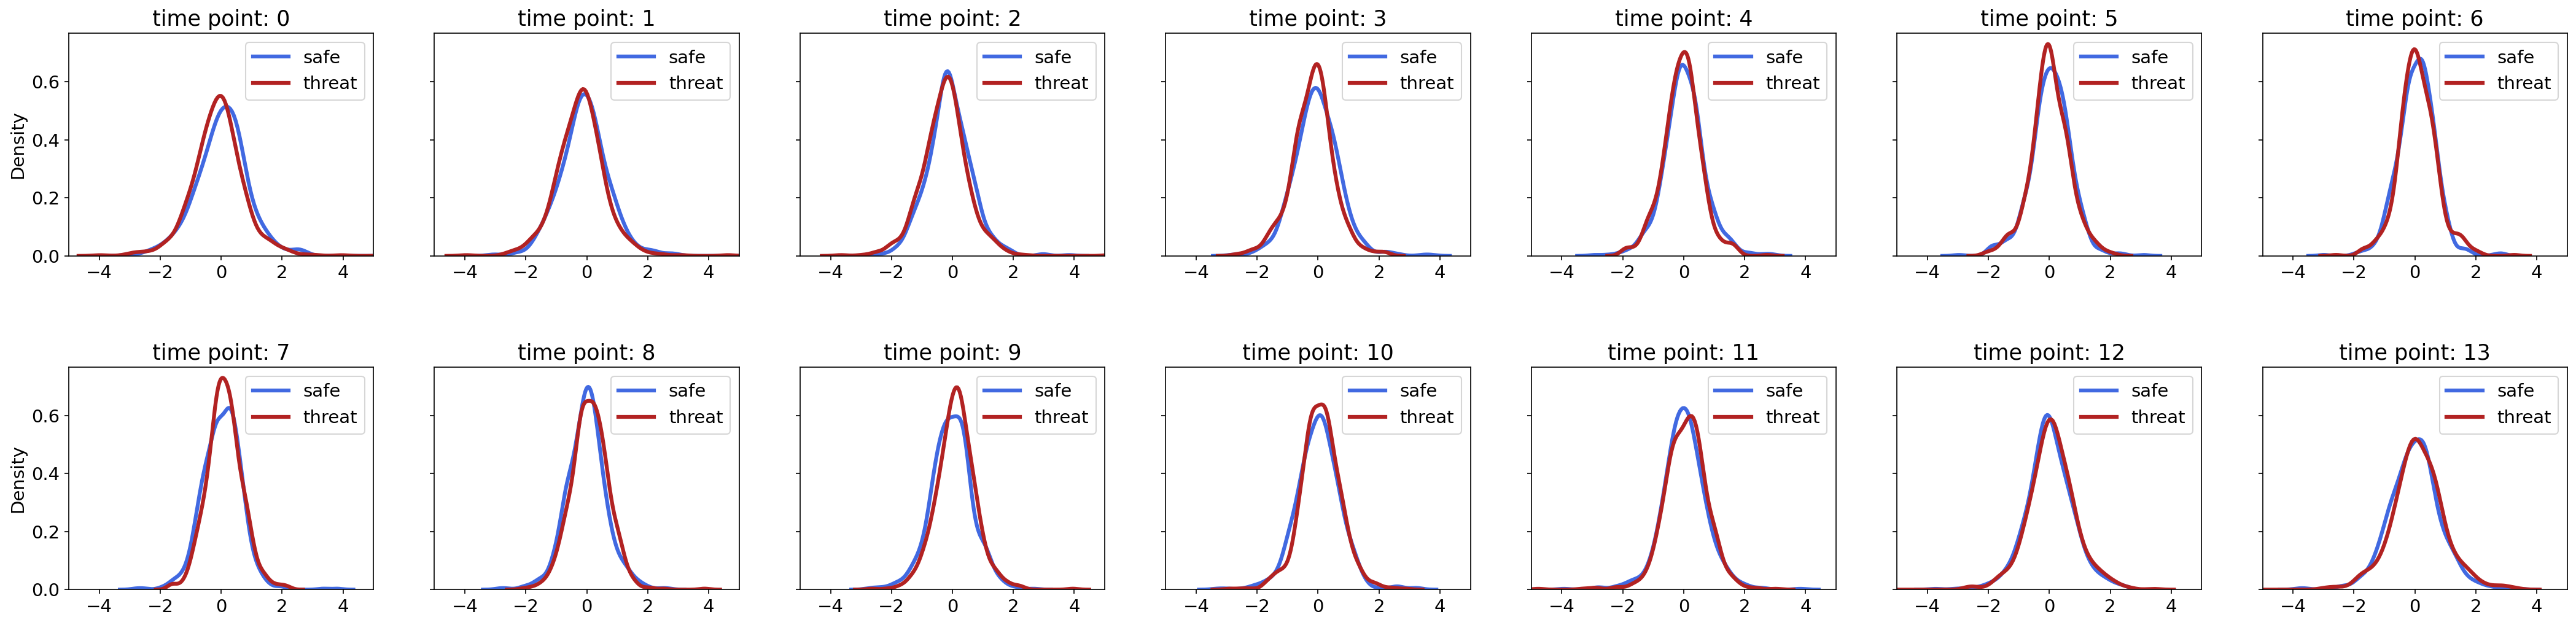

In [10]:
'''
ditribution of error around the mean for each time point
'''

import seaborn as sns

X, y = X_train, y_train
idx_roi = 45

X_conds = {}
for label in args.LABELS:
    idx = y[:, 0] == label
    X_conds[label] = X[idx, :, idx_roi].squeeze() - np.mean(X[idx, :, idx_roi], axis=1)[:, None]

time = np.arange(X.shape[1])
names = ['safe', 'threat']
colors = {0:'royalblue', 1:'firebrick'}
nrows, ncols = 2, 7

fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=(5*ncols, 4*nrows), 
        sharex=False, 
        sharey=True, 
        dpi=150
    )

plt.subplots_adjust(
    left=None, bottom=None, 
    right=None, top=None, 
    wspace=None, hspace=0.5
)

for idx_tp, tp in enumerate(time):
    ax = axs[idx_tp//ncols, np.mod(idx_tp,ncols)]

    ax.set_title(f"time point: {tp}")
    for label in args.LABELS:
        
        sns.kdeplot(
            x=X_conds[label][:, idx_tp],
            ax=ax,
            color=colors[label],
            label=names[label],
            linewidth=3
        )
    ax.set_xlim(-5.0, 5.0)
    ax.legend()

In [11]:
'''
white-noise 
-----------
1. std's for each roi and each tp
2. simulated data with i.i.d. normal noise (white noise) around mean time series
'''
def sim_data_white_additive_noise(X, y, noise_level=1.0):
    X_, y_ = [], []
    for label in args.LABELS:
        idx = y[:, 0] == label
        X_ += [np.random.normal(
            loc=np.mean(X[idx], axis=0), 
            scale=noise_level*np.std(X[idx], axis=0), 
            size=X[idx].shape
        )]
        y_ += [np.ones(shape=(X[idx].shape[:-1])) * label]

    X_ = np.concatenate(X_, axis=0)
    y_ = np.concatenate(y_, axis=0)

    perm = np.random.permutation(y_.shape[0])
    X_ = X_[perm]
    y_ = y_[perm]

    return X_, y_

In [12]:
X_train_, y_train_ = sim_data_white_additive_noise(X_train, y_train)
X_valid_, y_valid_ = sim_data_white_additive_noise(X_valid, y_valid)
X_test_, y_test_ = sim_data_white_additive_noise(X_test, y_test)

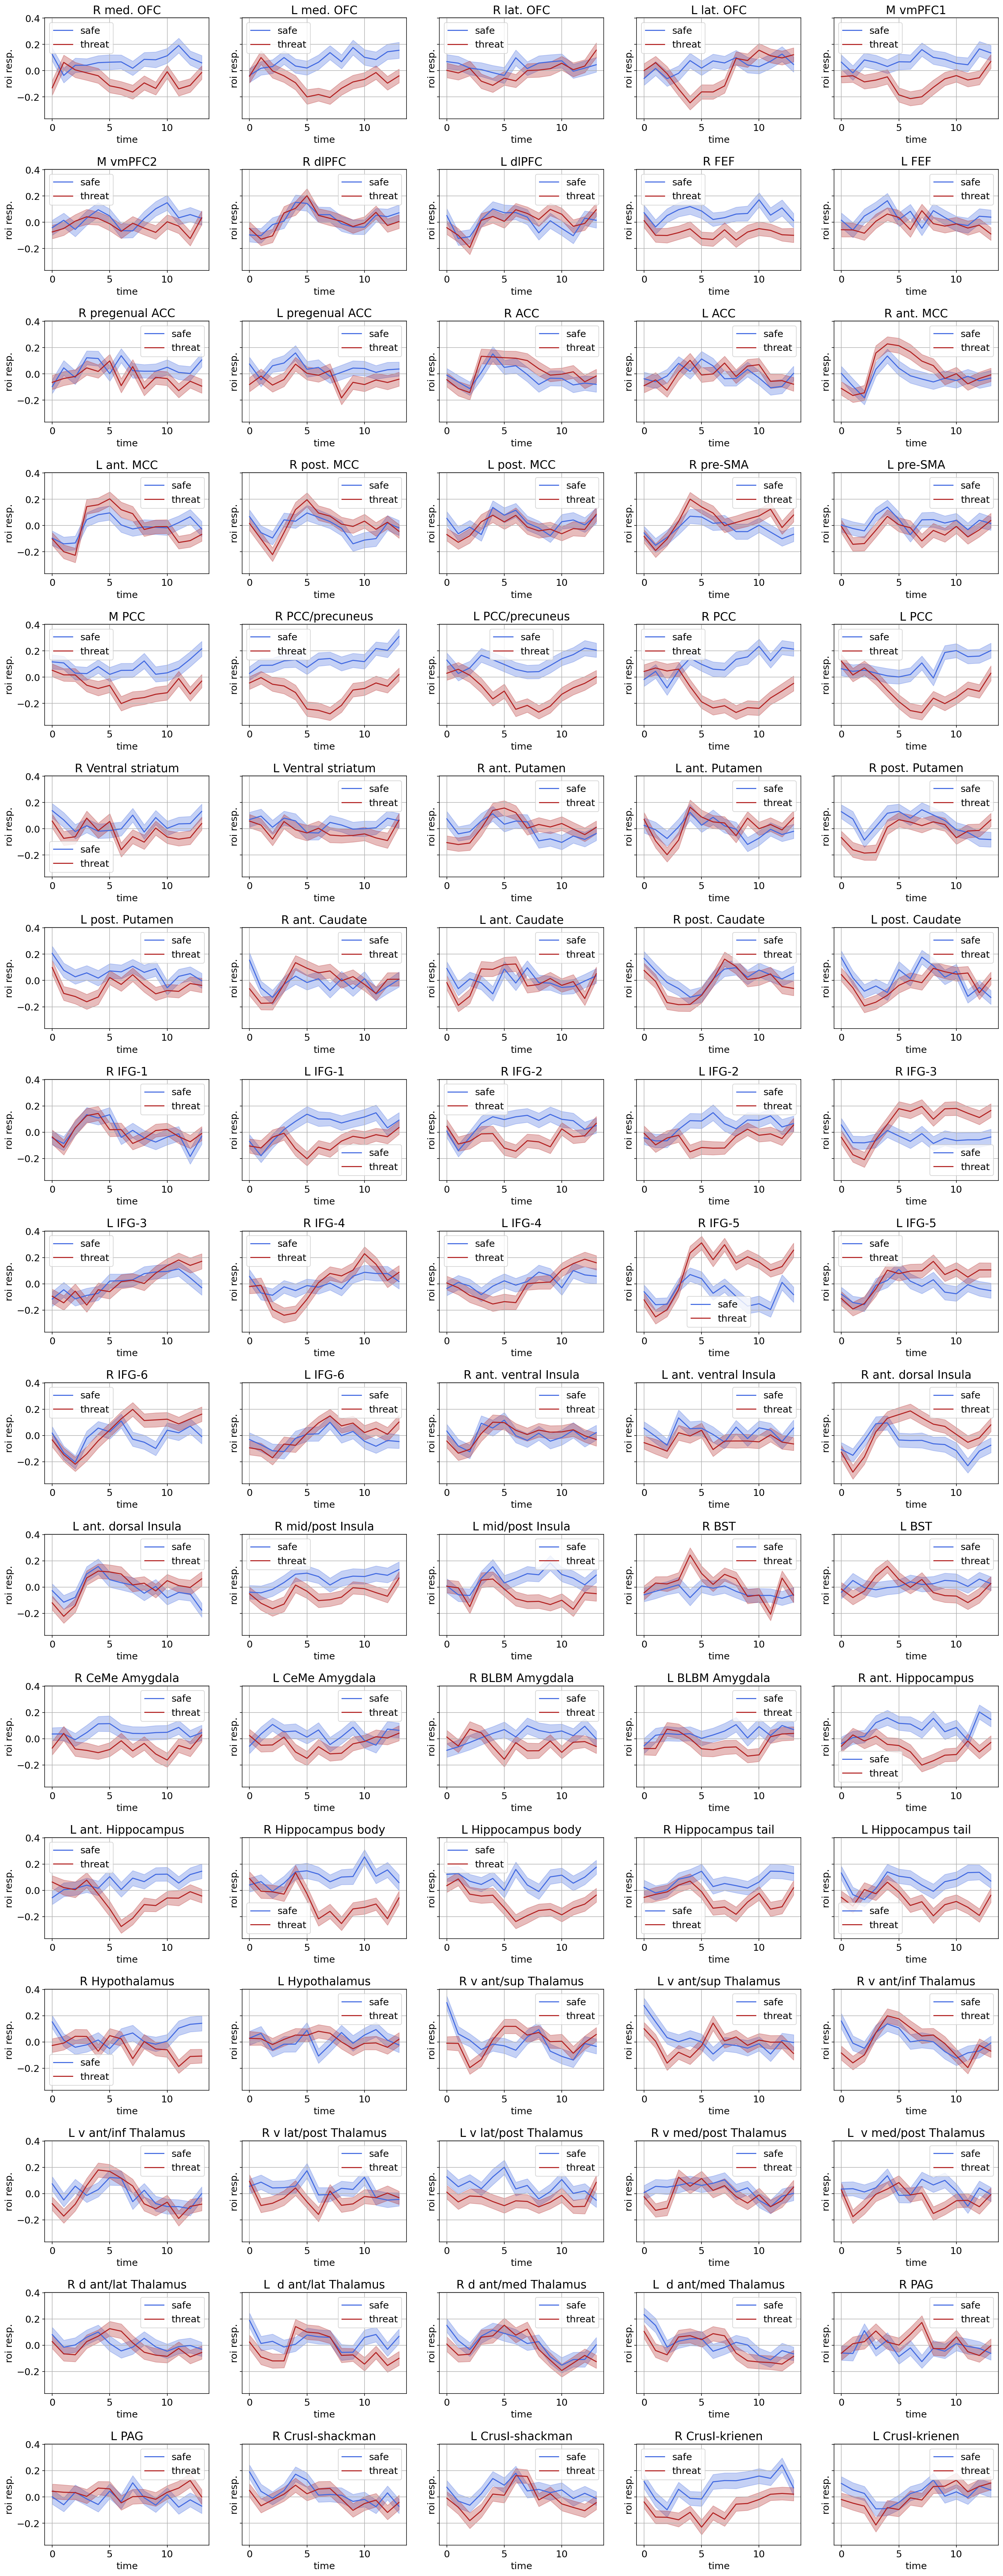

In [13]:
plot_roi_time_series(X_train_, y_train_)

### models

/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 01
	Train Loss: 0.731 | Train Acc: 50.33%
	 Val. Loss: 0.702 |  Val. Acc: 52.33%
Epoch: 02
	Train Loss: 0.706 | Train Acc: 52.51%
	 Val. Loss: 0.688 |  Val. Acc: 54.67%
Epoch: 03
	Train Loss: 0.693 | Train Acc: 54.37%
	 Val. Loss: 0.677 |  Val. Acc: 56.96%
Epoch: 04
	Train Loss: 0.676 | Train Acc: 57.03%
	 Val. Loss: 0.666 |  Val. Acc: 59.91%
Epoch: 05
	Train Loss: 0.666 | Train Acc: 58.76%
	 Val. Loss: 0.654 |  Val. Acc: 62.43%
Epoch: 06
	Train Loss: 0.654 | Train Acc: 61.07%
	 Val. Loss: 0.641 |  Val. Acc: 64.33%
Epoch: 07
	Train Loss: 0.638 | Train Acc: 63.60%
	 Val. Loss: 0.627 |  Val. Acc: 66.01%
Epoch: 08
	Train Loss: 0.621 | Train Acc: 65.78%
	 Val. Loss: 0.610 |  Val. Acc: 67.51%
Epoch: 09
	Train Loss: 0.600 | Train Acc: 67.93%
	 Val. Loss: 0.591 |  Val. Acc: 69.12%
Epoch: 10
	Train Loss: 0.578 | Train Acc: 70.25%
	 Val. Loss: 0.572 |  Val. Acc: 70.68%
Epoch: 11
	Train Loss: 0.558 | Train Acc: 71.68%
	 Val. Loss: 0.552 |  Val. Acc: 72.17%
Epoch: 12
	Train Loss: 0.537 | T

/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/torch/nn/modules/rnn.py:942: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


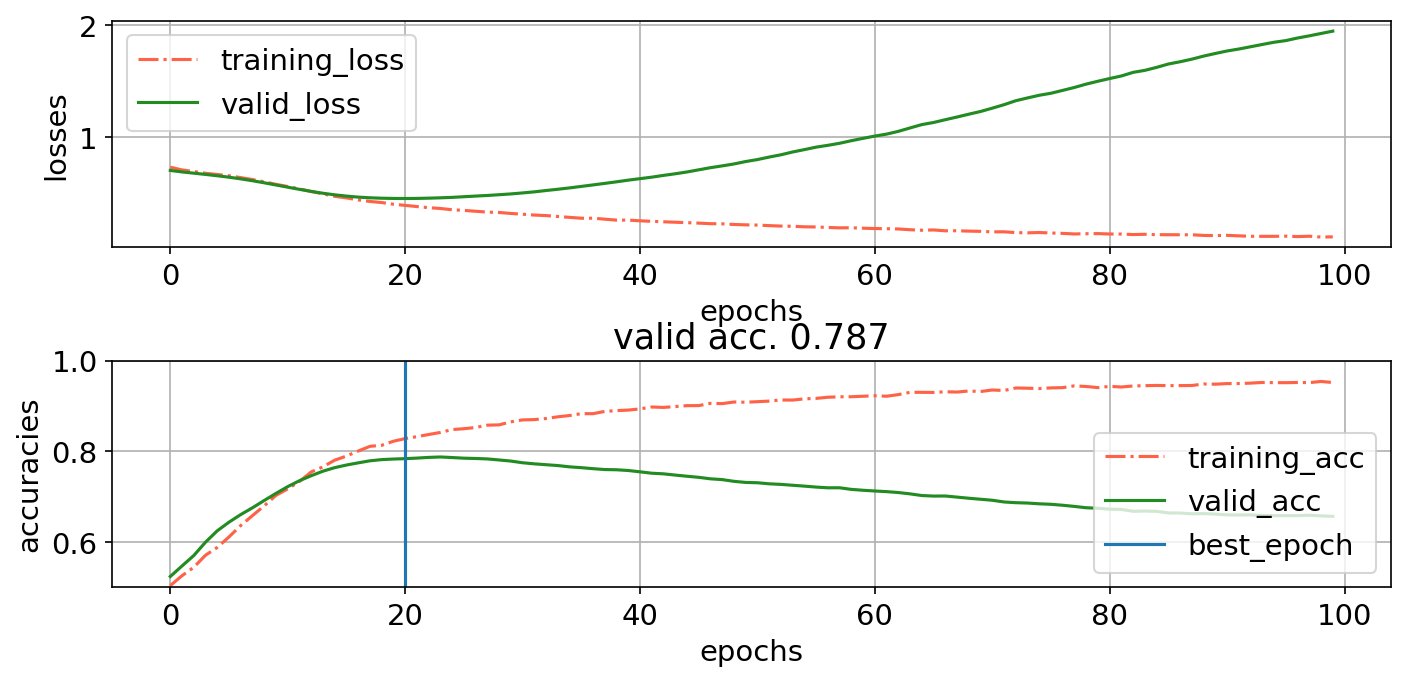

In [14]:
'''
model
'''
args.input_dim = X_train_.shape[-1]
args.out_dim = len(args.LABELS)
args.hidden_dim = 8
args.num_epochs = 100
args.batch_size = 64
# args.num_classes = len(args.LABELS)
args.dropout = 0.5

class GRU_classifier(nn.Module):
    def __init__(self, args):
        super(GRU_classifier, self).__init__()

        self.gru = nn.GRU(
            input_size=args.input_dim,
            hidden_size=args.hidden_dim,
            num_layers=1,
            batch_first=True,
            dropout=args.dropout
        )
        
        self.fc = nn.Linear(args.hidden_dim, args.out_dim)

        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x):
        x, hn = self.gru(x)
        x = self.dropout(x)
        y = self.fc(x)
        return y

    # def initHidden(self, args):
        # return torch.zeros(1, args.batch_size, args.num_units, device=device)

    def accuracy(self, y_pred, y_true):
        labels_pred = torch.argmax(y_pred, axis=-1)
        mask = (y_true != args.MASK).bool()
        correct = 1-torch.abs(labels_pred[mask] - y_true[mask])
        return correct.sum() / len(correct)

model = GRU_classifier(args)

criterion = nn.CrossEntropyLoss(ignore_index=args.MASK, reduction='mean')
optimizer = torch.optim.Adam(model.parameters())

model.to(device)
criterion.to(device)

data = (
    torch.FloatTensor(X_train_).to(device=device), torch.LongTensor(y_train_).to(device=device),
    torch.FloatTensor(X_valid_).to(device=device), torch.LongTensor(y_valid_).to(device=device),
    torch.FloatTensor(X_test_).to(device=device), torch.LongTensor(y_test_).to(device=device),
)

permut_train = torch.randperm(X_train_.shape[0])
permut_valid = torch.randperm(X_valid_.shape[0])

model, best_model, history, best_epoch = fit(data, model, criterion, optimizer)
plot_training_history(history, best_epoch)

print(f"valid: {evaluate(best_model, data[2], data[3], criterion, permut_valid)}")

permut_test = torch.randperm(X_test_.shape[0])
print(f"test: {evaluate(best_model, data[4], data[5], criterion, permut_test)}")

GRU model fits the data with ~79% accuracy on validation data. 
GRU model with either 8 units, or 16 units, or 32 units overfits on the training data and reaches ~79% on validation data.

/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 01
	Train Loss: 0.756 | Train Acc: 48.43%
	 Val. Loss: 0.720 |  Val. Acc: 50.53%
Epoch: 02
	Train Loss: 0.707 | Train Acc: 52.80%
	 Val. Loss: 0.677 |  Val. Acc: 57.64%
Epoch: 03
	Train Loss: 0.662 | Train Acc: 59.14%
	 Val. Loss: 0.633 |  Val. Acc: 67.32%
Epoch: 04
	Train Loss: 0.615 | Train Acc: 66.48%
	 Val. Loss: 0.583 |  Val. Acc: 74.65%
Epoch: 05
	Train Loss: 0.561 | Train Acc: 73.36%
	 Val. Loss: 0.525 |  Val. Acc: 79.31%
Epoch: 06
	Train Loss: 0.503 | Train Acc: 77.97%
	 Val. Loss: 0.463 |  Val. Acc: 82.83%
Epoch: 07
	Train Loss: 0.442 | Train Acc: 81.44%
	 Val. Loss: 0.402 |  Val. Acc: 85.18%
Epoch: 08
	Train Loss: 0.386 | Train Acc: 84.62%
	 Val. Loss: 0.347 |  Val. Acc: 86.97%
Epoch: 09
	Train Loss: 0.340 | Train Acc: 86.31%
	 Val. Loss: 0.301 |  Val. Acc: 88.39%
Epoch: 10
	Train Loss: 0.300 | Train Acc: 88.05%
	 Val. Loss: 0.266 |  Val. Acc: 89.65%
Epoch: 11
	Train Loss: 0.267 | Train Acc: 89.46%
	 Val. Loss: 0.240 |  Val. Acc: 90.43%
Epoch: 12
	Train Loss: 0.245 | T

/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/torch/nn/modules/rnn.py:942: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


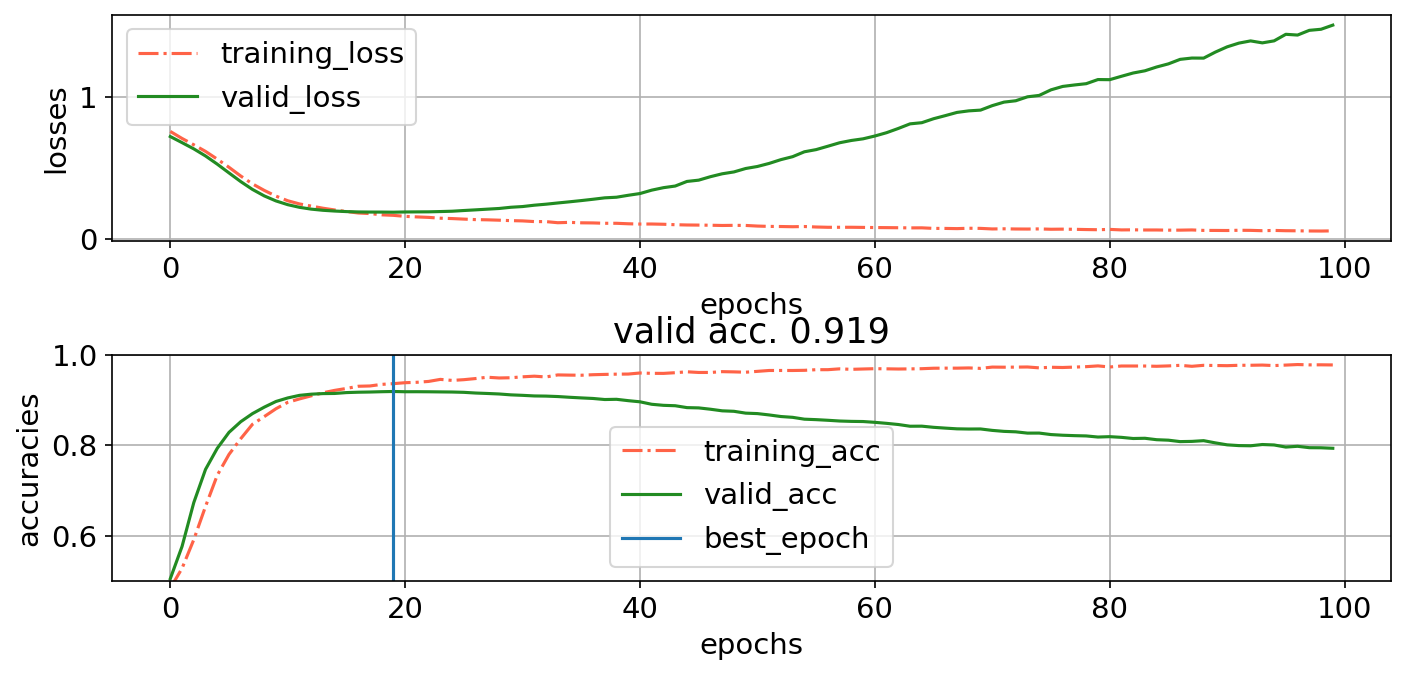

In [15]:
'''
reduce noise level and see model performance.
'''

'''
data with reduced noise level
'''
nl = 0.5
X_train_, y_train_ = sim_data_white_additive_noise(X_train, y_train, noise_level=nl)
X_valid_, y_valid_ = sim_data_white_additive_noise(X_valid, y_valid, noise_level=nl)
X_test_, y_test_ = sim_data_white_additive_noise(X_test, y_test, noise_level=nl)

'''
model
'''
args.input_dim = X_train_.shape[-1]
args.out_dim = len(args.LABELS)
args.hidden_dim = 8
args.num_epochs = 100
args.batch_size = 64
# args.num_classes = len(args.LABELS)
args.dropout = 0.5

class GRU_classifier(nn.Module):
    def __init__(self, args):
        super(GRU_classifier, self).__init__()

        self.gru = nn.GRU(
            input_size=args.input_dim,
            hidden_size=args.hidden_dim,
            num_layers=1,
            batch_first=True,
            dropout=args.dropout
        )
        
        self.fc = nn.Linear(args.hidden_dim, args.out_dim)

        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x):
        x, hn = self.gru(x)
        x = self.dropout(x)
        y = self.fc(x)
        return y

    # def initHidden(self, args):
        # return torch.zeros(1, args.batch_size, args.num_units, device=device)

    def accuracy(self, y_pred, y_true):
        labels_pred = torch.argmax(y_pred, axis=-1)
        mask = (y_true != args.MASK).bool()
        correct = 1-torch.abs(labels_pred[mask] - y_true[mask])
        return correct.sum() / len(correct)

model = GRU_classifier(args)

criterion = nn.CrossEntropyLoss(ignore_index=args.MASK, reduction='mean')
optimizer = torch.optim.Adam(model.parameters())

model.to(device)
criterion.to(device)

data = (
    torch.FloatTensor(X_train_).to(device=device), torch.LongTensor(y_train_).to(device=device),
    torch.FloatTensor(X_valid_).to(device=device), torch.LongTensor(y_valid_).to(device=device),
    torch.FloatTensor(X_test_).to(device=device), torch.LongTensor(y_test_).to(device=device),
)

permut_train = torch.randperm(X_train_.shape[0])
permut_valid = torch.randperm(X_valid_.shape[0])

model, best_model, history, best_epoch = fit(data, model, criterion, optimizer)
plot_training_history(history, best_epoch)

print(f"valid: {evaluate(best_model, data[2], data[3], criterion, permut_valid)}")

permut_test = torch.randperm(X_test_.shape[0])
print(f"test: {evaluate(best_model, data[4], data[5], criterion, permut_test)}")


/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 01
	Train Loss: 0.719 | Train Acc: 50.82%
	 Val. Loss: 0.693 |  Val. Acc: 50.03%
Epoch: 02
	Train Loss: 0.660 | Train Acc: 57.87%
	 Val. Loss: 0.635 |  Val. Acc: 58.16%
Epoch: 03
	Train Loss: 0.592 | Train Acc: 73.62%
	 Val. Loss: 0.559 |  Val. Acc: 86.63%
Epoch: 04
	Train Loss: 0.503 | Train Acc: 88.20%
	 Val. Loss: 0.456 |  Val. Acc: 93.58%
Epoch: 05
	Train Loss: 0.392 | Train Acc: 94.38%
	 Val. Loss: 0.341 |  Val. Acc: 94.65%
Epoch: 06
	Train Loss: 0.293 | Train Acc: 96.81%
	 Val. Loss: 0.248 |  Val. Acc: 94.71%
Epoch: 07
	Train Loss: 0.219 | Train Acc: 97.82%
	 Val. Loss: 0.188 |  Val. Acc: 94.68%
Epoch: 08
	Train Loss: 0.169 | Train Acc: 98.29%
	 Val. Loss: 0.154 |  Val. Acc: 94.63%
Epoch: 09
	Train Loss: 0.135 | Train Acc: 98.68%
	 Val. Loss: 0.133 |  Val. Acc: 94.66%
Epoch: 10
	Train Loss: 0.112 | Train Acc: 98.90%
	 Val. Loss: 0.120 |  Val. Acc: 94.72%
Epoch: 11
	Train Loss: 0.094 | Train Acc: 99.08%
	 Val. Loss: 0.111 |  Val. Acc: 94.83%
Epoch: 12
	Train Loss: 0.083 | T

/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/torch/nn/modules/rnn.py:942: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


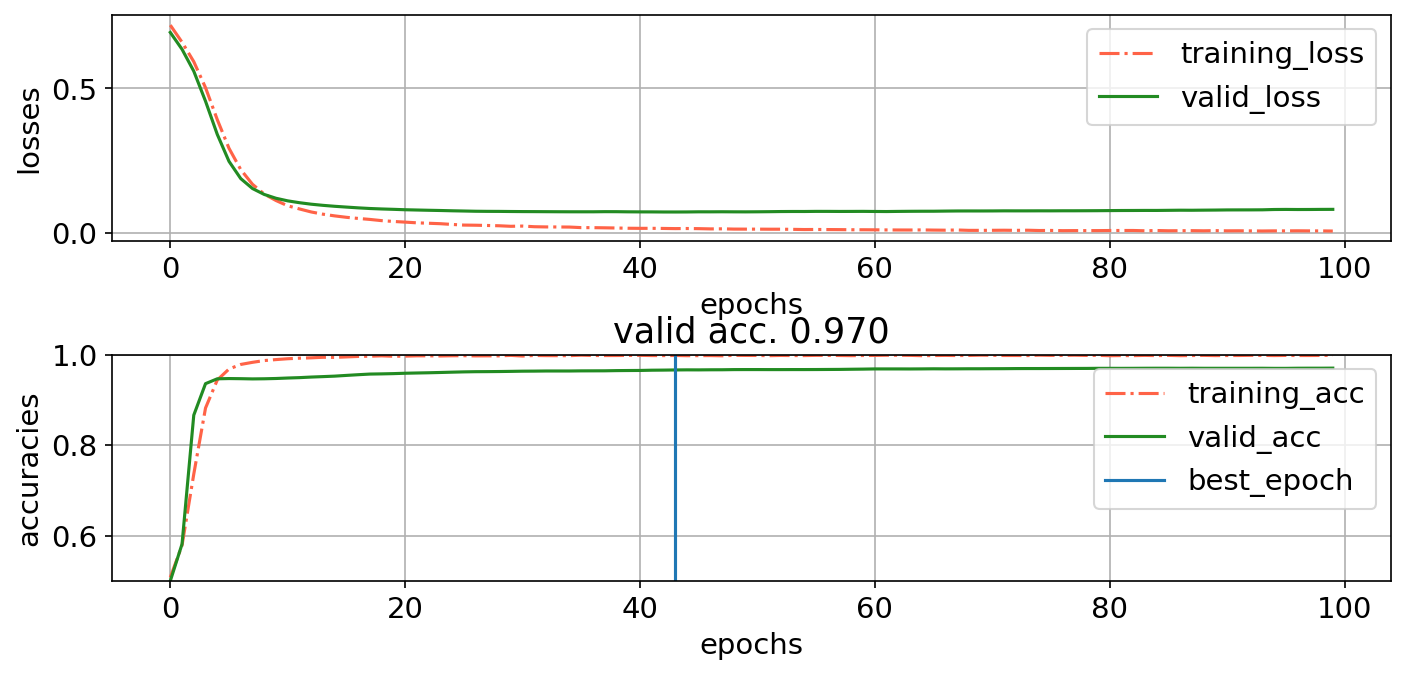

In [19]:
'''
reduce noise level and see model performance.
'''

'''
data with reduced noise level
'''
nl = 0.1
X_train_, y_train_ = sim_data_white_additive_noise(X_train, y_train, noise_level=nl)
X_valid_, y_valid_ = sim_data_white_additive_noise(X_valid, y_valid, noise_level=nl)
X_test_, y_test_ = sim_data_white_additive_noise(X_test, y_test, noise_level=nl)

'''
model
'''
args.input_dim = X_train_.shape[-1]
args.out_dim = len(args.LABELS)
args.hidden_dim = 8
args.num_epochs = 100
args.batch_size = 64
# args.num_classes = len(args.LABELS)
args.dropout = 0.5

class GRU_classifier(nn.Module):
    def __init__(self, args):
        super(GRU_classifier, self).__init__()

        self.gru = nn.GRU(
            input_size=args.input_dim,
            hidden_size=args.hidden_dim,
            num_layers=1,
            batch_first=True,
            dropout=args.dropout
        )
        
        self.fc = nn.Linear(args.hidden_dim, args.out_dim)

        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x):
        x, hn = self.gru(x)
        x = self.dropout(x)
        y = self.fc(x)
        return y

    # def initHidden(self, args):
        # return torch.zeros(1, args.batch_size, args.num_units, device=device)

    def accuracy(self, y_pred, y_true):
        labels_pred = torch.argmax(y_pred, axis=-1)
        mask = (y_true != args.MASK).bool()
        correct = 1-torch.abs(labels_pred[mask] - y_true[mask])
        return correct.sum() / len(correct)

model = GRU_classifier(args)

criterion = nn.CrossEntropyLoss(ignore_index=args.MASK, reduction='mean')
optimizer = torch.optim.Adam(model.parameters())

model.to(device)
criterion.to(device)

data = (
    torch.FloatTensor(X_train_).to(device=device), torch.LongTensor(y_train_).to(device=device),
    torch.FloatTensor(X_valid_).to(device=device), torch.LongTensor(y_valid_).to(device=device),
    torch.FloatTensor(X_test_).to(device=device), torch.LongTensor(y_test_).to(device=device),
)

permut_train = torch.randperm(X_train_.shape[0])
permut_valid = torch.randperm(X_valid_.shape[0])

model, best_model, history, best_epoch = fit(data, model, criterion, optimizer)
plot_training_history(history, best_epoch)

print(f"valid: {evaluate(best_model, data[2], data[3], criterion, permut_valid)}")

permut_test = torch.randperm(X_test_.shape[0])
print(f"test: {evaluate(best_model, data[4], data[5], criterion, permut_test)}")
